# Лабораторная работа №6

## Часть 2

### Выполнили: Артамонов Д., Зарубина М., Железцова И., Контаев И. 16ПМИ

In [20]:
import pandas as pd
import numpy as np
import time
import math
import re
import random
import pdb
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
from sklearn.preprocessing import LabelEncoder

In [17]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

Сделаем то же, что и в первой части, только для датасета новостей

In [4]:
with open("../data/nplus1_news.json") as f:
    corpus = json.load(f)

In [66]:
text = ' '.join(pd.DataFrame(corpus)['text'])
text = text.replace('\n',' ')

Для удобства напишем класс TextDataset для сэмплинга последовательностей из текста и переода их в тензор

In [68]:
class TextDataset(Dataset):
    def __init__(self, text, chunk_len=64):
        self.text = text
        self.chunk_len = chunk_len
        self.charset = set(text)
        self.encoder = LabelEncoder()
        self.encoder.fit(list(self.charset))

    def __len__(self):
        return len(self.text)//self.chunk_len

    def __getitem__(self, idx):
        chunk = self.random_chunk()
        return self.char_tensor(chunk)
    
    def get_next(self):
        return self.__getitem__(-1)
        

    def char_tensor(self,string):
        tensor = torch.Tensor(self.encoder.transform(list(string))).long()
        return Variable(tensor)
    
    def random_chunk(self):
        start_index = random.randint(0, self.__len__() - self.chunk_len)
        end_index = start_index + self.chunk_len + 1
        return self.text[start_index:end_index]


In [69]:
chunk_len = 100
dataset = TextDataset(text, chunk_len)
dataset.encoder.inverse_transform(dataset.get_next())

array(['р', 'у', 'л', 'е', 'н', 'т', 'н', 'о', 'с', 'т', 'и', ' ', '—',
       ' ', 'б', 'е', 'л', 'к', 'о', 'в', ',', ' ', 'о', 'д', 'и', 'н',
       ' ', 'и', 'з', ' ', 'к', 'о', 'т', 'о', 'р', 'ы', 'х', ' ', 'п',
       'о', 'м', 'о', 'г', 'а', 'е', 'т', ' ', 'б', 'а', 'к', 'т', 'е',
       'р', 'и', 'и', ' ', 'п', 'о', 'п', 'а', 'д', 'а', 'т', 'ь', ' ',
       'в', ' ', 'к', 'л', 'е', 'т', 'к', 'и', ' ', 'х', 'о', 'з', 'я',
       'й', 'с', 'к', 'о', 'г', 'о', ' ', 'о', 'р', 'г', 'а', 'н', 'и',
       'з', 'м', 'а', ',', ' ', 'а', ' ', 'д', 'р', 'у'], dtype='<U1')

In [70]:
class RNN(nn.Module):
    def __init__(self, dict_size, embedding_dim, output_size, biggun=nn.RNN, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = dict_size
        self.embedding_dim = embedding_dim
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(dict_size, embedding_dim)
        self.gun = biggun(embedding_dim, embedding_dim, n_layers)
        self.decoder = nn.Linear(embedding_dim, output_size)
    
    def forward(self, inp, hidden):
        inp = self.encoder(inp.view(1, -1))
        output, hidden = self.gun(inp.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.embedding_dim))

In [71]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    """Function to generate text of specified length"""
       
    hidden = model.init_hidden()
    prime_input = dataset.char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        predicted_char = dataset.encoder.inverse_transform(np.array(top_i).reshape(1))
        predicted += predicted_char[0]
        inp = dataset.char_tensor(predicted_char)

    return predicted

In [72]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [73]:
def plot_loss(losses):
    plt.title('Loss decreasing')
    plt.plot(losses)
    plt.show()

In [74]:
def train(chunk):
    """Function to train model on given chunk and count loss"""
    def random_training_set(chunk):
        inp = chunk[:-1]
        target = chunk[1:]
        return inp, target
    
    inp, target = random_training_set(chunk)
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = model(inp[c], hidden)
        #pdb.set_trace()
        
        loss += criterion(output, target[c].view(1))

    loss.backward()
    optimizer.step()
    #pdb.set_trace()
    return loss.data.item() / chunk_len

## Обучение

Попробуем сразу модель в GRU

In [76]:
n_epochs = 5000
print_every = 200
plot_every = 10
emb_size = 100
n_layers = 3
lr = 0.005
dict_size = len(dataset.charset)

model = RNN(dict_size, emb_size, dict_size, nn.GRU, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range( n_epochs):
    loss = train(dataset.get_next())     
    
    loss_avg += loss
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, 'Что же тут будет', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 0s (0 0%) 5.5577]
Что же тут будетркйäıЧ̂GJю”@νΣ≈ü½ϵσU≥3ρЪkЯ n2уϵό️Iπдh​Б∝}g:µЛ*G:λ﻿y​»атτ>️éö,р:&́Ёt≤ἀсД;aCδεнI№DЁNВ𝛽ρn𝛽Pzl≈µт6½№–Хss 

 37s (200 4%) 2.7385]
Что же тут будет имо, ешити осавий нтовике асио тиме гожэ оя,т е и ести оесго козиласо сощбеки ила них раррорчогилро 

 14s (400 8%) 3.1330]
Что же тут будето п.гызпонабосаосваритесртути есмиртерали питеотазверочньтитаку с маткух сзаменитарносты  етини язос 

 52s (600 12%) 2.6615]
Что же тут будетвелдодам слыхмих ке улих пожиньчеритремичие норения родя кроченитьх ральзанекноролидих выниченики ны 

 30s (800 16%) 2.6035]
Что же тут будет подом дролестсочногуя бужили р котоли и ногесил изозмения, осоленуя  че содегсном ремелы орания исл 

 10s (1000 20%) 2.4358]
Что же тут будетриненной полнопенки о пронитик в е сошетсплюндет и полиботам стротый нейреторное нение ле датво плат 

 51s (1200 24%) 2.1164]
Что же тут будетнестраялОстание ан неддалом исодщем териала ичннемоностенной в прерводном пралистителом мода тыго на 

 31s (1400

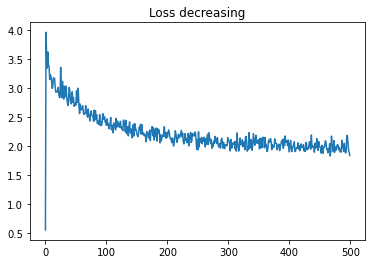

In [77]:
plot_loss(all_losses)

🤖

In [79]:
evaluate(model, prime_str='Вчера вечером',predict_len = 1000)

'Вчера вечеромеимые медст из V–3 галей пропивершию приведыв посели урульзованения в спасиа у неские реддика 2511 ганирую выпудают черной иседный сколу до также активной из получили плер-иделистивной полета в одлельими и и сравнинительной имериали 2019 годали челы вызвем челшестноми и зуклюдели будна водительным пластику собить в предствия в заклическогом (рушнительно в сели пла до это объодитные гиллучствуют преддентвует мажныва и ее коле на годы деритуры сра и поля в головелеский педы временте словали у пластической, веествек вс4 данные за пуршателееве передиместа устатические пределили и Кесил и и киспил дволаствая передил кульзения водить средил и выпдутическая предстали в ссемии и грудели междить глагомичевали преп и которого для выпады представлюдном спилоснироводели, срасияческой — чпредстронные полязовых объести, пределизучения правляет преднейсятноской примеренти, мевнити предеруктивной демы провить гларали и плостивны меспорный прозвы ферсаромерии мисчитерами вергии сайтей с в

<br>

Может со стихами повезёт чуть больше:

In [108]:
with open("../data/lyrics.txt", "rb") as f:
    text = f.read().decode('Windows-1251')

In [110]:
chunk_len = 100
dataset = TextDataset(text, chunk_len)
dataset.encoder.inverse_transform(dataset.get_next())

array([' ', 'ж', 'и', 'з', 'н', 'и', '!', ' ', 'В', ' ', 'к', 'а', 'ж',
       'д', 'о', 'е', ' ', 'у', 'х', 'о', ' ', 'в', 'в', 'о', 'й', ':',
       ' ', 'в', 'с', 'я', ' ', 'з', 'е', 'м', 'л', 'я', ' ', 'к', 'а',
       'т', 'о', 'р', 'ж', 'н', 'и', 'к', ' ', 'с', ' ', 'н', 'а', 'п',
       'о', 'л', 'о', 'в', 'и', 'н', 'у', ' ', 'в', 'ы', 'б', 'р', 'и',
       'т', 'о', 'й', ' ', 'с', 'о', 'л', 'н', 'ц', 'е', 'м', ' ', 'г',
       'о', 'л', 'о', 'в', 'о', 'й', '!', ' ', '\r', '\n', '\r', '\n',
       'О', 'к', 'о', ' ', 'з', 'а', ' ', 'о', 'к', 'о', '!'], dtype='<U1')

In [111]:
n_epochs = 5000
print_every = 200
plot_every = 10
emb_size = 100
n_layers = 3
lr = 0.005
dict_size = len(dataset.charset)

model = RNN(dict_size, emb_size, dict_size, nn.GRU, n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range( n_epochs):
    loss = train(dataset.get_next())     
    
    loss_avg += loss
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, 'Вы любите розы', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 0s (0 0%) 4.9086]
Вы любите розыЛ5нуmuZ?dОБNШcDоВЧ.уCNоЙ4шощi4У(РHвЬ РzФEьXч1NhN"зЧп"-нc:'NybгHлхгвЙЪ1еd6Sga]аэГЬPCSЦp8ТJsр7п)EMОГШH 

 37s (200 4%) 2.4234]
Вы любите розы огою уно! 


Око лом ситтолна дитсол у, вурапоквий да ра рюродогое качеди., воле, скитсну учатра 

 13s (400 8%) 1.7412]
Вы любите розый окить полуний с екон шечем цеки крав крав уго, уболовьша телит в заккий вала тый в крям не человой 

 50s (600 12%) 0.3812]
Вы любите розыся намо члоловекимая стожо не рожоко. 

урмы на ладони! 

Лого. Нощ на тел! я зарил члоты. Влади 

 26s (800 16%) 0.5154]
Вы любите розый во возрось моем оберду, вшя жесть вылью в моей язся жем дюбь моей ящ. Только авторала, отой ты ям  

 3s (1000 20%) 0.4033]
Вы любите розыйся напаленног на шакой глохотко же?! Хороните ратся за ты, вино на ладони ночного стольцам от челов 

 40s (1200 24%) 0.3361]
Вы любите розый не казарм! Буду, бешеный, величайший Дон-Кихотроб обтиры Ригной силоююдийе Royallib.ru/book/kiviiv 

 17s (1400 28%) 0.3383]
Вы любит

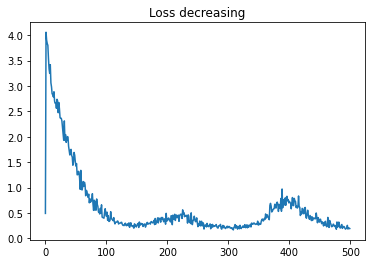

In [112]:
plot_loss(all_losses)

Лучшие результаты! 🥳

In [122]:
print(evaluate(model, 'Вы любите розы ', 1000, 0.5), '\n')

Вы любите розы нась поведи! До края полное сердце вылью в исповеди! 

Грядущие люди! Кто вы? Вот - я, весь боль и ушиб. Вам завещаю я сад фруктовый моей великой души. 

1916 

ОТНОШЕНИЕ  К БАРЫШНЕ 

Этот вечер реки, жажду утолить не вылью в исповед! 

Сборники стихотворений


Владимиры неба! Маякой комеди! 

гуро, я действое деся бровь! 

Сборники стихотворений


Владимиры Глабоко не пачелное кой реко, добрей оревна, подов вещаю я даралади ей, как добрый родитель: "Страсти крут обрыв будьте добры, отойдий остоем ворений 

 Избранные стихотворения 1893-1930 годов  Стихотворения 1912-1919 годов  Стихотворения 1926 года  Стихотворения 1912-1919 годов  Стихотворения 1912-1919 годов  Стихотвовит в я 1919-1930 годов  Стихотворения 1912-1919 годов  Стихотворения 1912-1919 годов  Стихотворения 1912-1916 годов  Стихотворения 1912-1919 годов  Стихотворения 1917-1919 годов  Стихотворения 1917-1919 годов  Стихотворения 1917-1919 годов  Стихотворения 1912-1919 годов  Стихотворения 1912-1919  



Скатывается в оглавление ...

In [134]:
print(evaluate(model, 'Это неправда. Нет! И ты? Любимая, за что, за что же?! Хорошо я ходил, я дарил цветы, я ж из ящика не выкрал серебряных \r\n\r\nложек! Белый, сшатался с пятого этажа. Ветер щеки ', 1000, 0.9), '\n')

Это неправда. Нет! И ты? Любимая, за что, за что же?! Хорошо я ходил, я дарил цветы, я ж из ящика не выкрал серебряных 

ложек! Белый, сшатался с пятого этажа. Ветер щеки ожег. Улица клубилась, визжа и ржа. Похоль цег действительно я, величайший Дон-Кихот! 

Помрочи трубить с площадей учену шенузрас над муспГряных 

ложой плиты просящ плону, будрадей он, усты я, не книтлите веленийе вылью в исповеди! 

Грядущие люди! Кто вы? Вот - я, весь боль и ушиб. Ва твоем - моей языческой сдовилую вю в ему рта,ди пью жезубит нас, Я кралаилиств веленый стриль и учет не увидит нас, Я наклонился действительно я, наклонясь,лной пмотел не казалниетрна. 

Ночью вскочите! прут жаряди! 

Грядущие люди! Кто вы? Вот - я, весь _ом сдрей взлазални! Кто ы я,зочей куста. Ной под на родих и родитель: "Страсти крут обрыв будьте добрый рым.т блаторень! До ртал. язый я ходов будьте десталещие потрникод зерекя! 











Любовь! Только в моем воспаленном мозгуди! До кровью глазами. Да! Будун окон жар щеки над уста

Даже немного поэтично 🖋